# Balanced risk set matching implementation on OASIS dataset
Submitted by: Alex Abainza & Mark Allen Jugalbot<br/>
CS3203 Data Analytics

## Reading dataset

In [60]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.formula.api as smf

In [61]:
df = pd.read_csv("oasis_dataset.csv")
df.head()

,entry_number,subject_id,visit,time_of_ad,m_f,educ,ses,age,mr_delay,e_tiv,n_wbv,asf
0,1,OAS2_0002,1,NaN,M,12,-1,75,0,1678,0.736,1.046
1,2,OAS2_0002,2,NaN,M,12,-1,76,560,1738,0.713,1.010
2,3,OAS2_0002,3,NaN,M,12,-1,80,1895,1698,0.701,1.034
3,4,OAS2_0007,1,3.0,M,16,-1,71,0,1357,0.748,1.293
4,5,OAS2_0007,3,3.0,M,16,-1,73,518,1365,0.727,1.286


In [62]:
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   entry_number  115 non-null    int64  
 1   subject_id    115 non-null    object 
 2   visit         115 non-null    int64  
 3   time_of_ad    29 non-null     float64
 4   m_f           115 non-null    object 
 5   educ          115 non-null    int64  
 6   ses           115 non-null    int64  
 7   age           115 non-null    int64  
 8   mr_delay      115 non-null    int64  
 9   e_tiv         115 non-null    int64  
 10  n_wbv         115 non-null    float64
 11  asf           115 non-null    float64
dtypes: float64(3), int64(7), object(2)
memory usage: 10.9+ KB


,entry_number,subject_id,visit,time_of_ad,m_f,educ,ses,age,mr_delay,e_tiv,n_wbv,asf
0,1,OAS2_0002,1,NaN,M,12,-1,75,0,1678,0.736,1.046
1,2,OAS2_0002,2,NaN,M,12,-1,76,560,1738,0.713,1.010
2,3,OAS2_0002,3,NaN,M,12,-1,80,1895,1698,0.701,1.034
3,4,OAS2_0007,1,3.0,M,16,-1,71,0,1357,0.748,1.293
4,5,OAS2_0007,3,3.0,M,16,-1,73,518,1365,0.727,1.286
5,6,OAS2_0007,4,3.0,M,16,-1,75,1281,1372,0.710,1.279
6,7,OAS2_0009,1,NaN,M,12,2,68,0,1457,0.806,1.205
7,8,OAS2_0009,2,NaN,M,12,2,69,576,1480,0.791,1.186
8,9,OAS2_0010,1,NaN,F,12,3,66,0,1447,0.769,1.213
9,10,OAS2_0010,2,NaN,F,12,3,68,854,1482,0.752,1.184


## Data Preprocessing

In [63]:
df.drop(columns=["entry_number"], inplace=True)

In [64]:
df.head()

,subject_id,visit,time_of_ad,m_f,educ,ses,age,mr_delay,e_tiv,n_wbv,asf
0,OAS2_0002,1,NaN,M,12,-1,75,0,1678,0.736,1.046
1,OAS2_0002,2,NaN,M,12,-1,76,560,1738,0.713,1.010
2,OAS2_0002,3,NaN,M,12,-1,80,1895,1698,0.701,1.034
3,OAS2_0007,1,3.0,M,16,-1,71,0,1357,0.748,1.293
4,OAS2_0007,3,3.0,M,16,-1,73,518,1365,0.727,1.286


In [65]:
df.sort_values(by=["subject_id", "visit"], inplace=True)
df["m_f"] = df["m_f"].astype("category")


In [66]:
print(df['ses'].value_counts())
# ses values which are -1 are likely empty
df["ses"] = df["ses"].replace(-1, np.nan)

ses
 4    31
 3    29
-1    19
 2    19
 1    15
 5     2
Name: count, dtype: int64


In [67]:
df.head()

,subject_id,visit,time_of_ad,m_f,educ,ses,age,mr_delay,e_tiv,n_wbv,asf
0,OAS2_0002,1,NaN,M,12,NaN,75,0,1678,0.736,1.046
1,OAS2_0002,2,NaN,M,12,NaN,76,560,1738,0.713,1.010
2,OAS2_0002,3,NaN,M,12,NaN,80,1895,1698,0.701,1.034
3,OAS2_0007,1,3.0,M,16,NaN,71,0,1357,0.748,1.293
4,OAS2_0007,3,3.0,M,16,NaN,73,518,1365,0.727,1.286


In [68]:
age_stats = df["age"].describe()
educ_stats = df["educ"].describe()

age_stats, educ_stats


(count    115.000000
 mean      76.400000
 std        6.495342
 min       62.000000
 25%       72.000000
 50%       76.000000
 75%       81.000000
 max       92.000000
 Name: age, dtype: float64,
 count    115.000000
 mean      13.582609
 std        2.837662
 min        6.000000
 25%       12.000000
 50%       12.000000
 75%       16.000000
 max       20.000000
 Name: educ, dtype: float64)

In [69]:
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
subject_id     0
visit          0
time_of_ad    86
m_f            0
educ           0
ses           19
age            0
mr_delay       0
e_tiv          0
n_wbv          0
asf            0
dtype: int64


In [70]:
# identify patients who had a change of time of ad - likely to have been diagnosed
df["is_diagnosed"] = np.where(df["time_of_ad"].isin([2, 3]), 1, 0)


In [71]:
df = df.rename(columns={
    'subject_id': 'participant_id',
    'visit': 'visit_number',
    'time_of_ad': 'assessment_time',
    'm_f': 'gender',
    'educ': 'education_years',
    'ses': 'socioeconomic_status',
    'age': 'age_at_visit',
    'mr_delay': 'mri_scan_delay',
    'e_tiv': 'estimated_total_intracranial_volume',
    'n_wbv': 'normalized_brain_volume',
    'asf': 'atlas_scaling_factor',
    'is_diagnosed': 'diagnosed'
})


In [72]:
df["gender"] = df["gender"].map({"F":0, "M":1})

In [73]:
df.head(20)

,participant_id,visit_number,assessment_time,gender,education_years,socioeconomic_status,age_at_visit,mri_scan_delay,estimated_total_intracranial_volume,normalized_brain_volume,atlas_scaling_factor,diagnosed
0,OAS2_0002,1,NaN,1,12,NaN,75,0,1678,0.736,1.046,0
1,OAS2_0002,2,NaN,1,12,NaN,76,560,1738,0.713,1.010,0
2,OAS2_0002,3,NaN,1,12,NaN,80,1895,1698,0.701,1.034,0
3,OAS2_0007,1,3.0,1,16,NaN,71,0,1357,0.748,1.293,1
4,OAS2_0007,3,3.0,1,16,NaN,73,518,1365,0.727,1.286,1
5,OAS2_0007,4,3.0,1,16,NaN,75,1281,1372,0.710,1.279,1
6,OAS2_0009,1,NaN,1,12,2.0,68,0,1457,0.806,1.205,0
7,OAS2_0009,2,NaN,1,12,2.0,69,576,1480,0.791,1.186,0
8,OAS2_0010,1,NaN,0,12,3.0,66,0,1447,0.769,1.213,0
9,OAS2_0010,2,NaN,0,12,3.0,68,854,1482,0.752,1.184,0


## Mini EDA
Goal: Identify which variables seem to have an effect on the if diagnosed

In [74]:
categorical_vars = ["gender", "socioeconomic_status"]
discrete_vars = ['education_years', 'age_at_visit']
continuous_vars = ['estimated_total_intracranial_volume', 'normalized_brain_volume', 'atlas_scaling_factor']
p_values = {}


### On categorical values (gender, socioeconomic status)
Using continuous variables (e.g. estimated_total_intracranial_volume, normalized_brain_volume, atlas_scaling_factor


In [75]:

for var in categorical_vars:
    contingency_table = pd.crosstab(df[var], df['diagnosed'])
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    p_values[var] = p


### On discrete and categorical values


In [76]:
for var in discrete_vars + continuous_vars:
    t_stat, p = stats.ttest_ind(df[df['diagnosed'] == 1][var], df[df['diagnosed'] == 0][var], equal_var=False)
    p_values[var] = p

In [77]:
formula = "diagnosed ~ " + " + ".join(categorical_vars + discrete_vars + continuous_vars)
logit_model = smf.logit(formula, data=df).fit()
logit_p_values = logit_model.pvalues.to_dict()

Optimization terminated successfully.
         Current function value: 0.352171
         Iterations 10


## Visualizing data for possible relationships on categorical variables (economic status, gender)

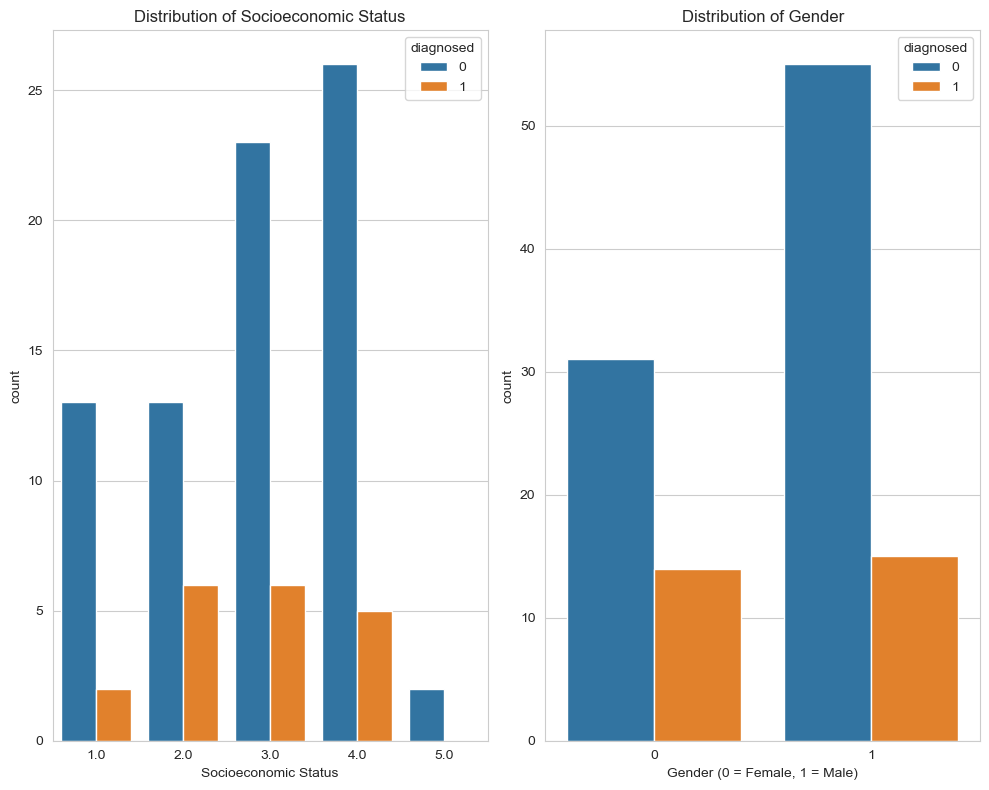

In [87]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")  

fig, axes = plt.subplots(1, 2, figsize=(10, 8))

sns.countplot(data=df, x="socioeconomic_status", hue="diagnosed", ax=axes[0])
axes[0].set_title("Distribution of Socioeconomic Status")
axes[0].set_xlabel("Socioeconomic Status")

sns.countplot(data=df, x="gender", hue="diagnosed", ax=axes[1])
axes[1].set_title("Distribution of Gender")
axes[1].set_xlabel("Gender (0 = Female, 1 = Male)")

# Adjust layout
plt.tight_layout()
plt.show()


### Observations
#### Socioeconomic Status (Bottom Left: Bar Chart)

Socioeconomic Status does not seem to strongly differentiate diagnosed from undiagnosed patients.


#### Gender (Bottom Right: Bar Chart)

The proportion of diagnosed individuals appears similar for both genders.

## Visualizing data for possible relationships on discrete variables (age, years of education)

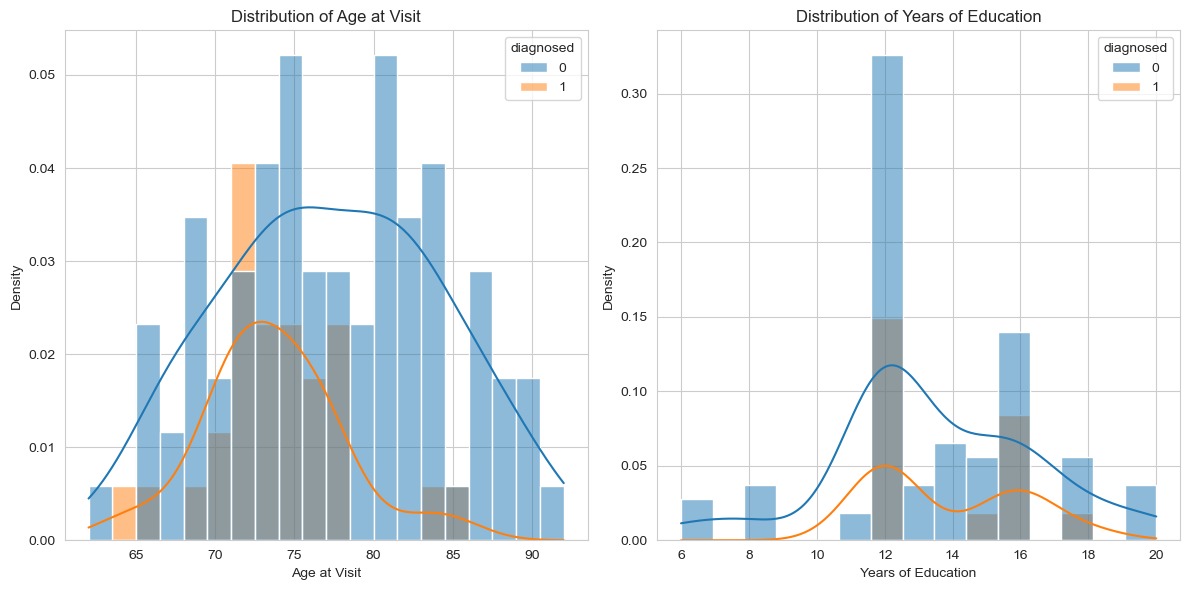

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")  

# Create 1 row, 2 columns of subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot Age at Visit distribution
sns.histplot(df, x="age_at_visit", hue="diagnosed", bins=20, kde=True, stat="density", ax=axes[0], alpha=0.5)
axes[0].set_title("Distribution of Age at Visit")
axes[0].set_xlabel("Age at Visit")

# Plot Years of Education distribution
sns.histplot(df, x="education_years", hue="diagnosed", bins=15, kde=True, stat="density", ax=axes[1], alpha=0.5)
axes[1].set_title("Distribution of Years of Education")
axes[1].set_xlabel("Years of Education")

# Adjust layout
plt.tight_layout()
plt.show()


### Observations
#### Age at Visit Graph

Diagnosed patients are more concentrated at 70-75 years old. Undiagnosed patients have a wider spread peaking around 75-80 years old.<br/>

Since the distribution is not identical, age could possibly influence diagnosed.

#### Years of Education

Most individuals, both diagnosed and undiagnosed, have 12-16 years of education. There is a significant overlap, meaning education may not be a strong distinguishing factor.




## Visualizing data for possible relationships on continuous variables (estimated_total_intracranial_volume, normalized_brain_volume, atlas_scaling_factor)

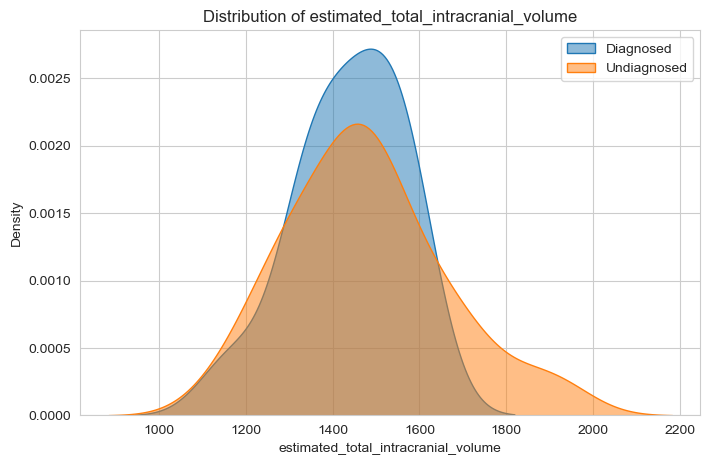

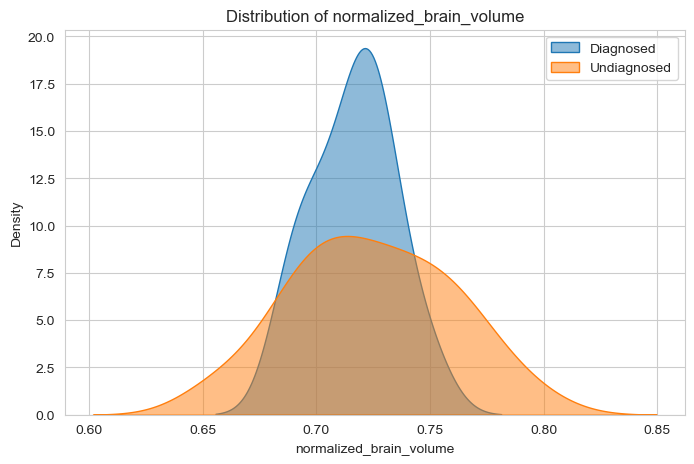

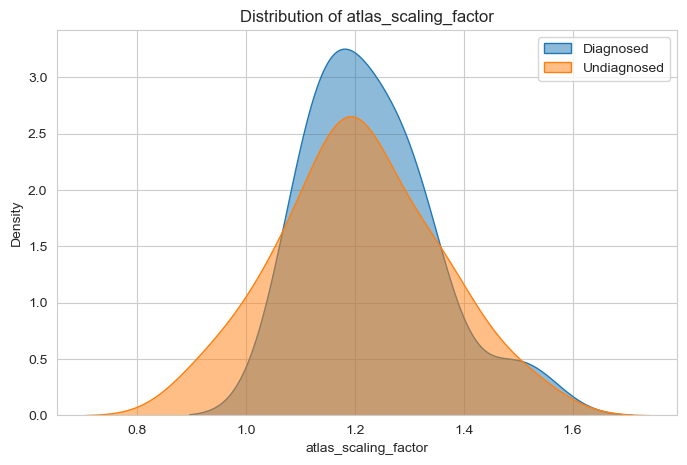

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.set_style("whitegrid")


for col in ['estimated_total_intracranial_volume', 'normalized_brain_volume', 'atlas_scaling_factor']:
    plt.figure(figsize=(8, 5))
    sns.kdeplot(df_diagnosed[col], label="Diagnosed", fill=True, alpha=0.5)
    sns.kdeplot(df_undiagnosed[col], label="Undiagnosed", fill=True, alpha=0.5)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.legend()
    plt.show()


#### If there is a significant difference, it will be added as a covariate
From the results below, it is the **age at visit** and the **normalized brain volume** that seem to have an impact on diagnosed

In [92]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

# Define X (features) and y (target)
X = df[['estimated_total_intracranial_volume', 'normalized_brain_volume', 'atlas_scaling_factor']]
y = df['diagnosed']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train decision tree
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)

# Get feature importances
feature_importances = tree.feature_importances_

# Print results
for var, importance in zip(X.columns, feature_importances):
    print(f"Feature Importance for {var}: {importance:.3f}")

# Evaluate model
y_pred = tree.predict(X_test)
print(f"\nDecision Tree Accuracy: {accuracy_score(y_test, y_pred):.3f}")


Feature Importance for estimated_total_intracranial_volume: 0.371
Feature Importance for normalized_brain_volume: 0.330
Feature Importance for atlas_scaling_factor: 0.298

Decision Tree Accuracy: 0.696


In [94]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

# Define features and target variable
X = df[['age_at_visit', 'gender', 'education_years', 'socioeconomic_status']]
y = df['diagnosed']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train decision tree
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)

# Get feature importances
feature_importances = tree.feature_importances_

# Print results
for var, importance in zip(X.columns, feature_importances):
    print(f"Feature Importance for {var}: {importance:.3f}")


Feature Importance for age_at_visit: 0.359
Feature Importance for gender: 0.094
Feature Importance for education_years: 0.394
Feature Importance for socioeconomic_status: 0.153


In [78]:
results_df = pd.DataFrame({
    'Variable': list(p_values.keys()),
    'P-Value (T-Test/Chi-Square)': list(p_values.values()),
    'P-Value (Logistic Regression)': [logit_p_values.get(var, None) for var in p_values.keys()]
})

# Add significance flag
results_df['Significant? (p < 0.05)'] = results_df.apply(lambda row: '✅ Yes' if row['P-Value (T-Test/Chi-Square)'] < 0.05 or row['P-Value (Logistic Regression)'] < 0.05 else '🚫 No', axis=1)

# Display results
print(results_df)

                              Variable  P-Value (T-Test/Chi-Square)  \
0                               gender                     0.343671   
1                 socioeconomic_status                     0.587134   
2                      education_years                     0.475551   
3                         age_at_visit                     0.001287   
4  estimated_total_intracranial_volume                     0.073508   
5              normalized_brain_volume                     0.372852   
6                 atlas_scaling_factor                     0.147997   

   P-Value (Logistic Regression) Significant? (p < 0.05)  
0                            NaN                    🚫 No  
1                       0.681475                    🚫 No  
2                       0.330006                    🚫 No  
3                       0.008011                   ✅ Yes  
4                       0.073679                    🚫 No  
5                       0.008984                   ✅ Yes  
6                 

Using discrete variables

## Performing balanced risk set matching

In [24]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
from scipy.linalg import inv

# Select only necessary columns
matching_df = df[['participant_id', 'diagnosed', 'age_at_visit', 'normalized_brain_volume']]

# Split into diagnosed (cases) and undiagnosed (controls)
cases = matching_df[matching_df['diagnosed'] == 1].copy()
controls = matching_df[matching_df['diagnosed'] == 0].copy()

# Compute inverse covariance matrix for Mahalanobis distance
cov_matrix = np.cov(matching_df[['age_at_visit', 'normalized_brain_volume']].T)
inv_cov_matrix = inv(cov_matrix)

# Function to compute Mahalanobis distance
def mahalanobis_distance(row1, row2):
    return np.sqrt((row1 - row2) @ inv_cov_matrix @ (row1 - row2).T)

# Match each diagnosed patient to the closest undiagnosed patient
matched_pairs = []
for _, case in cases.iterrows():
    case_vector = case[['age_at_visit', 'normalized_brain_volume']].values.reshape(1, -1)
    control_vectors = controls[['age_at_visit', 'normalized_brain_volume']].values
    
    distances = cdist(case_vector, control_vectors, metric='mahalanobis', VI=inv_cov_matrix)
    best_match_index = np.argmin(distances)
    
    best_match = controls.iloc[best_match_index]
    matched_pairs.append((case['participant_id'], best_match['participant_id'], distances[0, best_match_index]))

# Convert to DataFrame
matched_df = pd.DataFrame(matched_pairs, columns=['case_id', 'control_id', 'mahalanobis_distance'])

# Save matched data
matched_df.to_csv("matched_data.csv", index=False)

print("✅ Matching complete. Results saved to 'matched_data.csv'")


✅ Matching complete. Results saved to 'matched_data.csv'


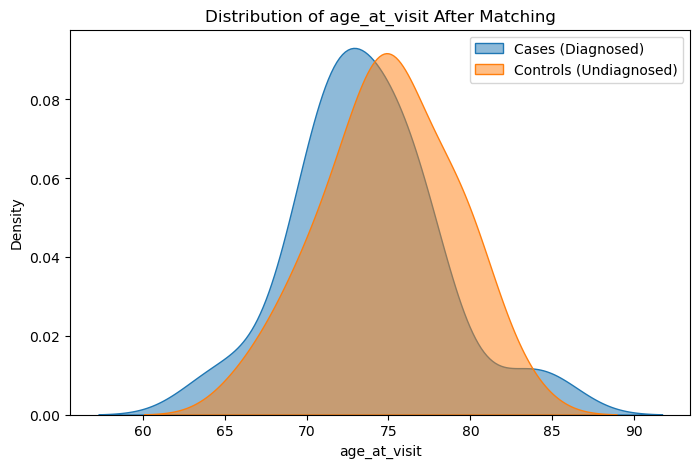

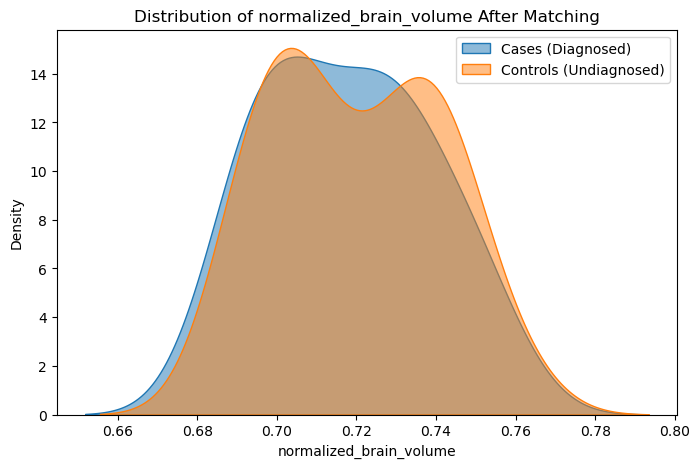

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Merge matched cases and controls
matched_cases = df[df['participant_id'].isin(matched_df['case_id'])]
matched_controls = df[df['participant_id'].isin(matched_df['control_id'])]

# Plot distributions before and after matching
for col in ['age_at_visit', 'normalized_brain_volume']:
    plt.figure(figsize=(8, 5))
    sns.kdeplot(matched_cases[col], label="Cases (Diagnosed)", fill=True, alpha=0.5)
    sns.kdeplot(matched_controls[col], label="Controls (Undiagnosed)", fill=True, alpha=0.5)
    plt.title(f'Distribution of {col} After Matching')
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.legend()
    plt.show()


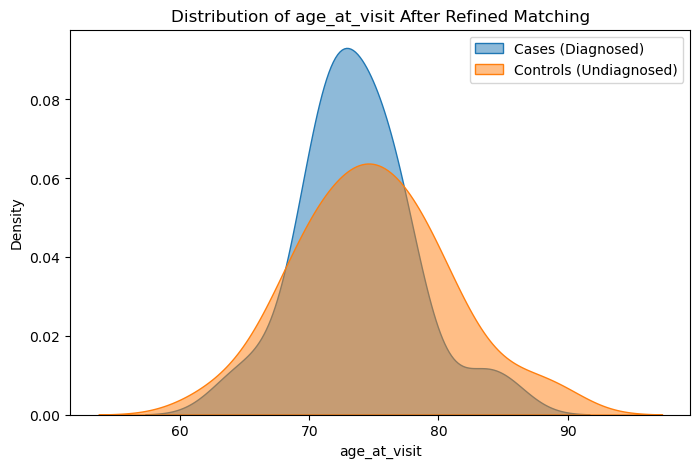

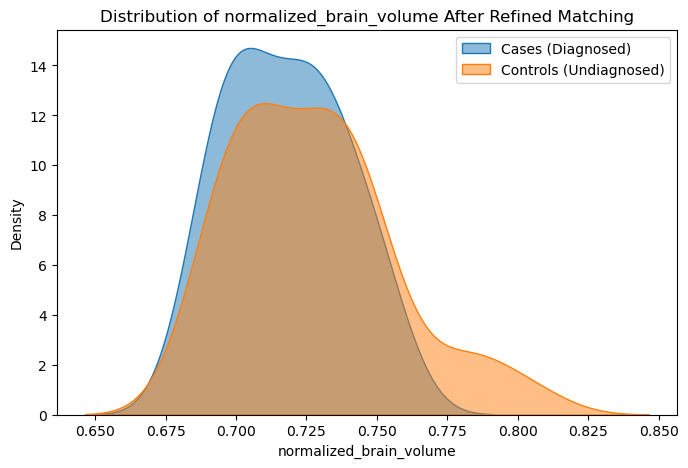

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Load refined matches
matched_cases = df[df['participant_id'].isin(matched_df['case_id'])]
matched_controls = df[df['participant_id'].isin(matched_df['control_id'])]

# Plot KDE for age and brain volume after refined matching
for col in ['age_at_visit', 'normalized_brain_volume']:
    plt.figure(figsize=(8, 5))
    sns.kdeplot(matched_cases[col], label="Cases (Diagnosed)", fill=True, alpha=0.5)
    sns.kdeplot(matched_controls[col], label="Controls (Undiagnosed)", fill=True, alpha=0.5)
    plt.title(f'Distribution of {col} After Refined Matching')
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.legend()
    plt.show()


In [30]:
from scipy.spatial.distance import mahalanobis
from scipy.linalg import inv

# Compute inverse covariance matrix for Mahalanobis distance
cov_matrix = np.cov(df[['age_at_visit', 'normalized_brain_volume']].T)
inv_cov_matrix = inv(cov_matrix)

# Define a caliper (threshold for Mahalanobis distance)
CALIPER = 0.1  # Adjust based on dataset distribution

# Perform matching with caliper
matched_pairs = []
for _, case in cases.iterrows():
    case_vector = case[['age_at_visit', 'normalized_brain_volume']].values.reshape(1, -1)
    control_vectors = controls[['age_at_visit', 'normalized_brain_volume']].values
    
    distances = cdist(case_vector, control_vectors, metric='mahalanobis', VI=inv_cov_matrix)
    min_distance = np.min(distances)
    
    if min_distance < CALIPER:  # Only match if within caliper
        best_match_index = np.argmin(distances)
        best_match = controls.iloc[best_match_index]
        matched_pairs.append((case['participant_id'], best_match['participant_id'], min_distance))

# Convert to DataFrame
matched_df = pd.DataFrame(matched_pairs, columns=['case_id', 'control_id', 'mahalanobis_distance'])

# Save refined matches
matched_df.to_csv("refined_matched_data.csv", index=False)
print("✅ Matching complete with caliper. Results saved to 'refined_matched_data.csv'")


✅ Matching complete with caliper. Results saved to 'refined_matched_data.csv'


In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors

# Define variables for PSM
X = df[['age_at_visit', 'normalized_brain_volume']]
y = df['diagnosed']

# Fit logistic regression to get propensity scores
logit = LogisticRegression()
df['propensity_score'] = logit.fit(X, y).predict_proba(X)[:, 1]

# Separate cases and controls based on propensity score
cases = df[df['diagnosed'] == 1].copy()
controls = df[df['diagnosed'] == 0].copy()

# Match each case to the closest control based on propensity score
nn = NearestNeighbors(n_neighbors=1, metric="euclidean")
nn.fit(controls[['propensity_score']])
distances, indices = nn.kneighbors(cases[['propensity_score']])

# Store matched pairs
matched_pairs = [(cases.iloc[i]['participant_id'], controls.iloc[indices[i][0]]['participant_id'], distances[i][0]) for i in range(len(cases))]

# Save results
matched_df = pd.DataFrame(matched_pairs, columns=['case_id', 'control_id', 'propensity_distance'])
matched_df.to_csv("psm_matched_data.csv", index=False)
print("✅ Propensity Score Matching complete. Results saved to 'psm_matched_data.csv'")


✅ Propensity Score Matching complete. Results saved to 'psm_matched_data.csv'


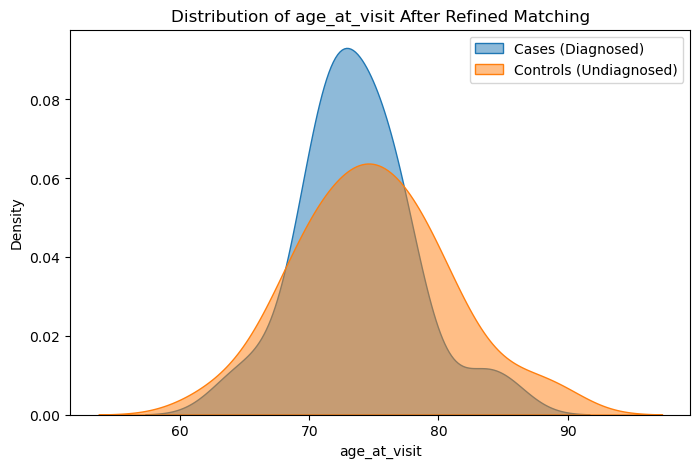

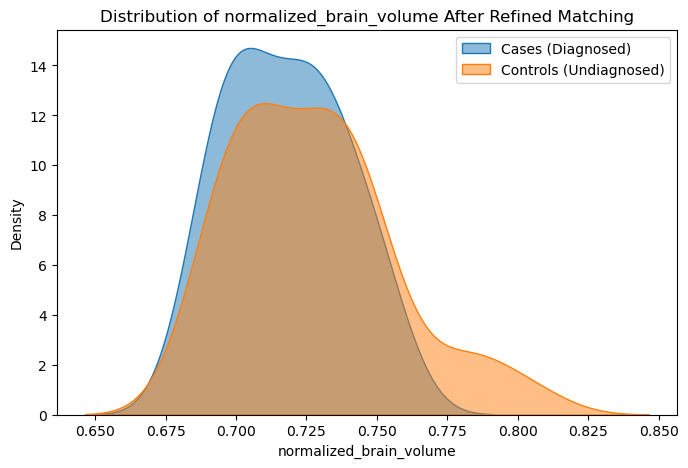

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Load refined matches
matched_cases = df[df['participant_id'].isin(matched_df['case_id'])]
matched_controls = df[df['participant_id'].isin(matched_df['control_id'])]

# Plot KDE for age and brain volume after refined matching
for col in ['age_at_visit', 'normalized_brain_volume']:
    plt.figure(figsize=(8, 5))
    sns.kdeplot(matched_cases[col], label="Cases (Diagnosed)", fill=True, alpha=0.5)
    sns.kdeplot(matched_controls[col], label="Controls (Undiagnosed)", fill=True, alpha=0.5)
    plt.title(f'Distribution of {col} After Refined Matching')
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.legend()
    plt.show()


ValueError: x and y must be the same size

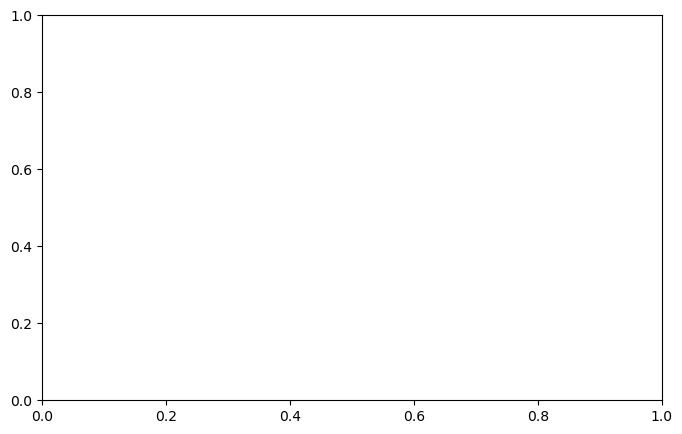

In [33]:
plt.figure(figsize=(8, 5))
plt.scatter(matched_cases['age_at_visit'], matched_controls['age_at_visit'], alpha=0.5)
plt.xlabel("Case Age at Visit")
plt.ylabel("Control Age at Visit")
plt.title("Age at Visit: Case vs. Matched Control")
plt.show()


In [96]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.linalg import inv
from scipy.stats import ttest_ind

# Load dataset
# df = pd.read_csv("your_dataset.csv")

# Define selected covariates
covariates = ['education_years', 'age_at_visit', 'estimated_total_intracranial_volume', 
              'normalized_brain_volume', 'atlas_scaling_factor']

# Optional: Add socioeconomic_status if needed
use_ses = False  # Set to True if testing SES inclusion
if use_ses:
    covariates.append('socioeconomic_status')

# Separate diagnosed (cases) and undiagnosed (controls)
cases = df[df['diagnosed'] == 1].copy()
controls = df[df['diagnosed'] == 0].copy()


In [97]:
# Compute inverse covariance matrix for Mahalanobis distance
cov_matrix = np.cov(df[covariates].T)
inv_cov_matrix = inv(cov_matrix)

# Function to compute Mahalanobis distance
def mahalanobis_distance(row1, row2):
    return np.sqrt((row1 - row2) @ inv_cov_matrix @ (row1 - row2).T)

# Match each diagnosed patient to the closest undiagnosed patient
matched_pairs = []
for _, case in cases.iterrows():
    case_vector = case[covariates].values.reshape(1, -1)
    control_vectors = controls[covariates].values
    
    distances = cdist(case_vector, control_vectors, metric='mahalanobis', VI=inv_cov_matrix)
    best_match_index = np.argmin(distances)
    
    best_match = controls.iloc[best_match_index]
    matched_pairs.append((case['participant_id'], best_match['participant_id'], distances[0, best_match_index]))

# Convert to DataFrame
matched_df = pd.DataFrame(matched_pairs, columns=['case_id', 'control_id', 'mahalanobis_distance'])

# Save matched dataset
matched_df.to_csv("matched_data.csv", index=False)
print("✅ Matching complete. Results saved to 'matched_data.csv'")


✅ Matching complete. Results saved to 'matched_data.csv'


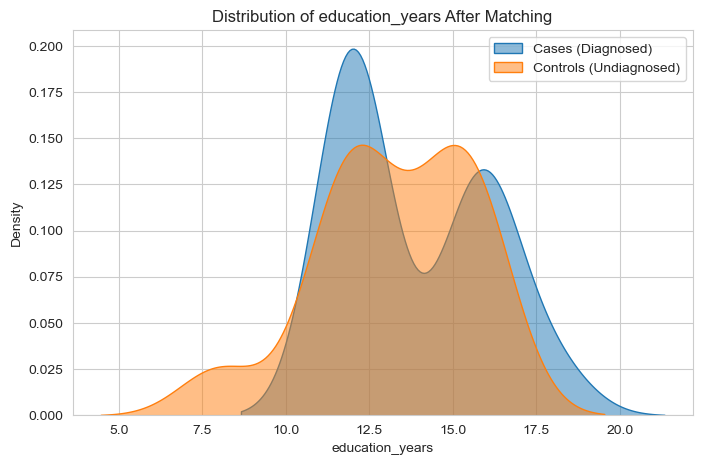

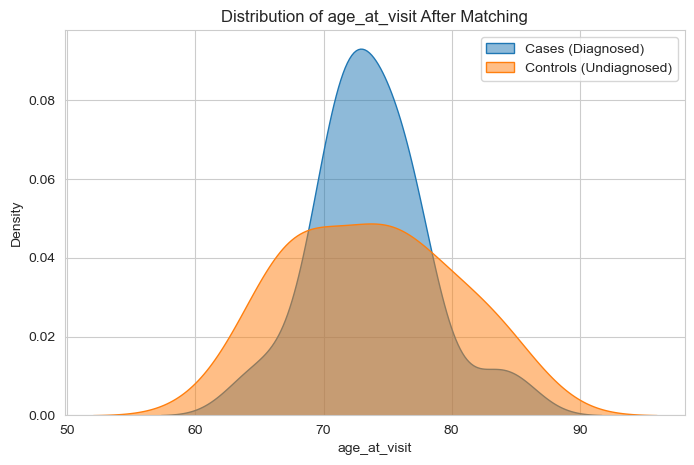

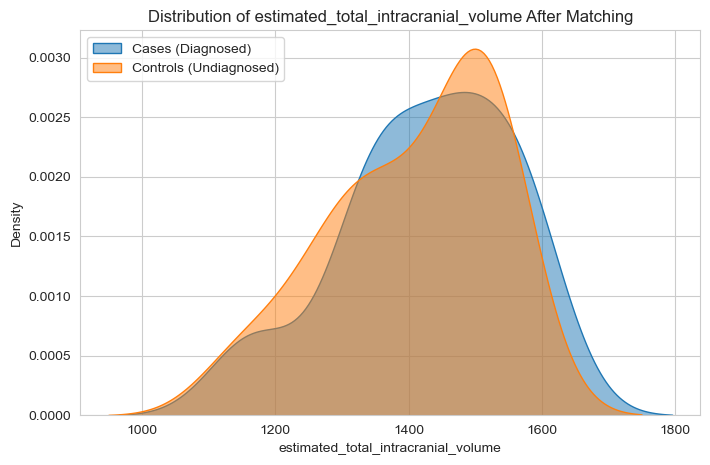

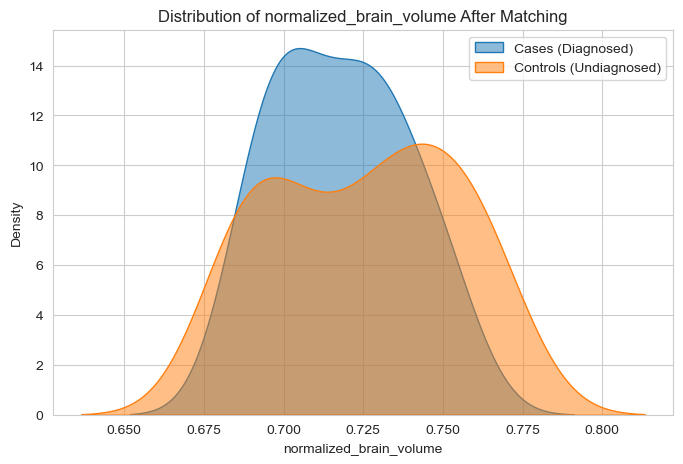

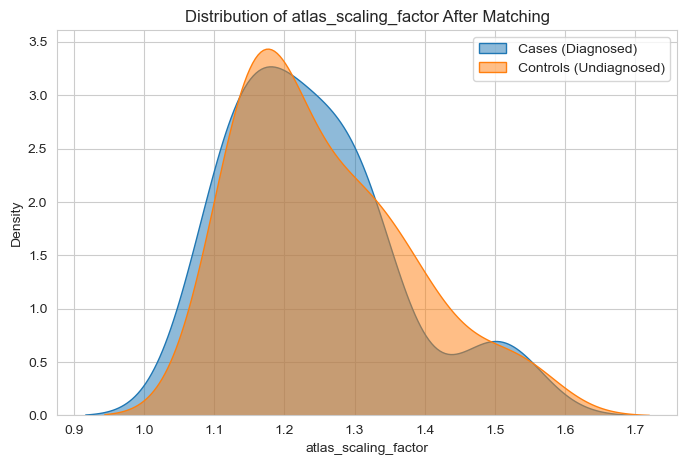

In [98]:
# Load matched data
matched_cases = df[df['participant_id'].isin(matched_df['case_id'])]
matched_controls = df[df['participant_id'].isin(matched_df['control_id'])]

# Plot distributions
for col in covariates:
    plt.figure(figsize=(8, 5))
    sns.kdeplot(matched_cases[col], label="Cases (Diagnosed)", fill=True, alpha=0.5)
    sns.kdeplot(matched_controls[col], label="Controls (Undiagnosed)", fill=True, alpha=0.5)
    plt.title(f'Distribution of {col} After Matching')
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.legend()
    plt.show()


In [102]:
matched_df

,case_id,control_id,mahalanobis_distance
